# Task 51 - PCA Analysis of UsArrests.csv

## Exploring the data

In [61]:
# Importing Libraries
import numpy as np
import pandas as pd

# For preprocessing
import missingno
from sklearn.preprocessing import MinMaxScaler

# For clustering
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pca import pca
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

# Evaluation metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, silhouette_score

# For visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

In [62]:
def corr_heatmap(df, colormap):
    """
    Function to produce correlation heatmap of given data
    """
    # get correlations
    corrs = df.corr()

    # pick appropriate palette for heatmap

    # Plot figsize
    fig, ax = plt.subplots(figsize=(8, 8))

    # to mask mirrored side of heatmap
    dropSelf = np.zeros_like(corrs)
    dropSelf[np.triu_indices_from(dropSelf)] = True

    # Generate Heat Map, with annotations of the correlation strength and 2-decimal floats
    ax = sns.heatmap(corrs, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf, linewidth=2)

    plt.title("Correlation Feature Heatmap")
    plt.show()

In [63]:
def biplot(score,coeff,labels=None,points=None, xlabel = None, ylabel = None, title = None):
    """
    Function to create PCA biplot of 2 PCAs
    """
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots(figsize=(8,8))    

    ax.scatter(xs * scalex,ys * scaley,s=50)

    for i in range(0,len(xs)):
        txt = states[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5 , head_width = 0.05, head_length = 0.05)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.title(title, size = 8)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()

    # Adapted from: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

In [64]:
def scatter_Kmeans(suptitle, xlabel, ylabel,x, k, r=123):
    """
    Function to create Kmeans scatter plot and silhoutte scores.
    """
    # Run KMeans CLuster Model.
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=r)
    # Stored Kmeans model results. 
    y_pred = kmeans.fit_predict(x)
    
    # Create Plot
    colours = 'rbgcmy'
    for c in range(k):
      plt.scatter(x[y_pred == c, 0], x[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
      plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')
    
    # Calculate Silhoutte Score form sklearn metrics 
    score = round(silhouette_score(X, kmeans.labels_, metric='euclidean'),2)
    
    # Customise Plot
    plt.suptitle(suptitle, size = 16)
    plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
    plt.close()
    
    return y_pred

In [65]:
def confusion_heatmap(cm_df):
    """
    Function to convert cm_df into heatmap plot
    """

    # Convert cm_df to heatmap plot
    sns.heatmap(cm_df, annot=True, cmap='Blues')

    #Customise PLot
    plt.title("Confusion Matrix")
    plt.ylabel("K-means Cluster IDs")
    plt.xlabel("Agglomerative Cluster IDs")

    # Show Plot
    plt.show()
    plt.close()

    # TP, FP
    # FN, TN

### Preprocessing

Note - Data description, this data set contains statistics in arrests per 100,00 residents for assult, murder, and rape in each of the 50 US States in 1973. Also given is the percentage of the population living in urban areas.

- Murder - Murder Arrests per 100,000 residents,
- Assault - Assaults arrests per 100,000 residents,
- Rape - Rapes arrests per 100,000 residents,
- UrbanPOp - Percentage urban population.

In [66]:
# Load UsArrests.csv and create datafram
usArrests_df = pd.read_csv("UsArrests.csv")

# Rename column 'City' to 'State'.
usArrests_df.rename(columns = {'City' : 'State'}, inplace= True)

# Create copy of Us_arrests
usArrests_copy_df = usArrests_df.copy()

# Set index column
usArrests_df = usArrests_df.set_index("State")

#Show Df
usArrests_df.head()

,Murder,Assault,UrbanPop,Rape
State,,,,
Alabama,13.20,236,58,21.20
Alaska,10.00,263,48,44.50
Arizona,8.10,294,80,31.00
Arkansas,8.80,190,50,19.50
California,9.00,276,91,40.60


In [67]:
# Look at dfs information.
usArrests_df.info()

print('\nNumber of cases: {} Number of features: {}'.format(usArrests_df.shape[0],usArrests_df.shape[1]))

# At present, no columns are to be dropped. 
# Feature titles look appropriate.
# DTypes look appropriate.
# Categorical data for 'City'.
# Continuous data for other feature classes.
# Apparently no missing or nan values.

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB

Number of cases: 50 Number of features: 4


<AxesSubplot: >

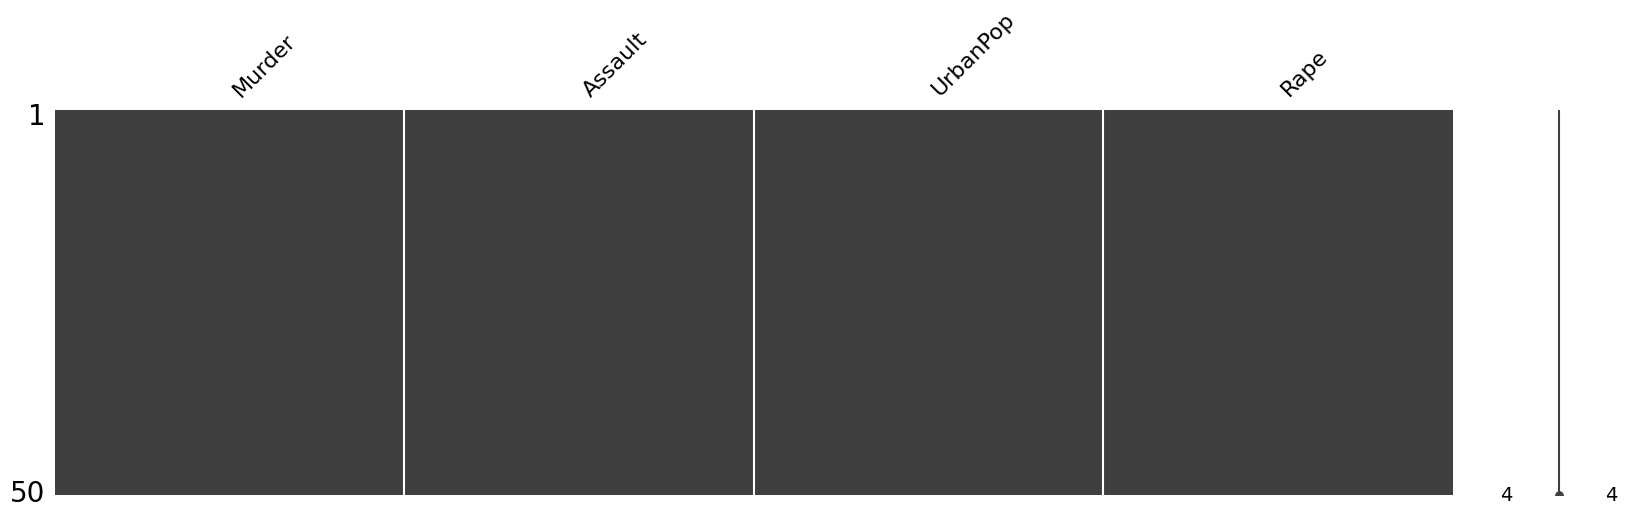

In [68]:
# Visualise missing data (if present)
missingno.matrix(usArrests_df, figsize = (20,5))

# Data appears good, no absense of values. Columns complete.

In [69]:
# Rename column 'City' to 'State'.
usArrests_df.rename(columns = {'City' : 'State'}, inplace= True)

In [70]:
# Make numerical features all float types
usArrests_df["Assault"] = usArrests_df["Assault"].astype("float64")
usArrests_df["UrbanPop"] = usArrests_df["UrbanPop"].astype("float64")

# Check astype on features.
usArrests_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     float64
 2   UrbanPop  50 non-null     float64
 3   Rape      50 non-null     float64
dtypes: float64(4)
memory usage: 2.0+ KB


In [71]:
#To set the decimal precision:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

# Look at dfs statistical information
stats = usArrests_df.describe()
selected_stats = stats.loc[["mean","std","min","max"]].transpose() #select relevant rows
selected_stats

# We have a larger variance between murder and assault. 
# Normalising should allow better visualisation and interpretability.
# Data appear to fall into expected magnitude ranges for Murder, Rape, Assault.

,mean,std,min,max
Murder,7.79,4.36,0.80,17.40
Assault,170.76,83.34,45.00,337.00
UrbanPop,65.54,14.47,32.00,91.00
Rape,21.23,9.37,7.30,46.00


# Initial EDA

Gain an initial understanding of the data to see any initial strong relationships or clusters of data emerging.

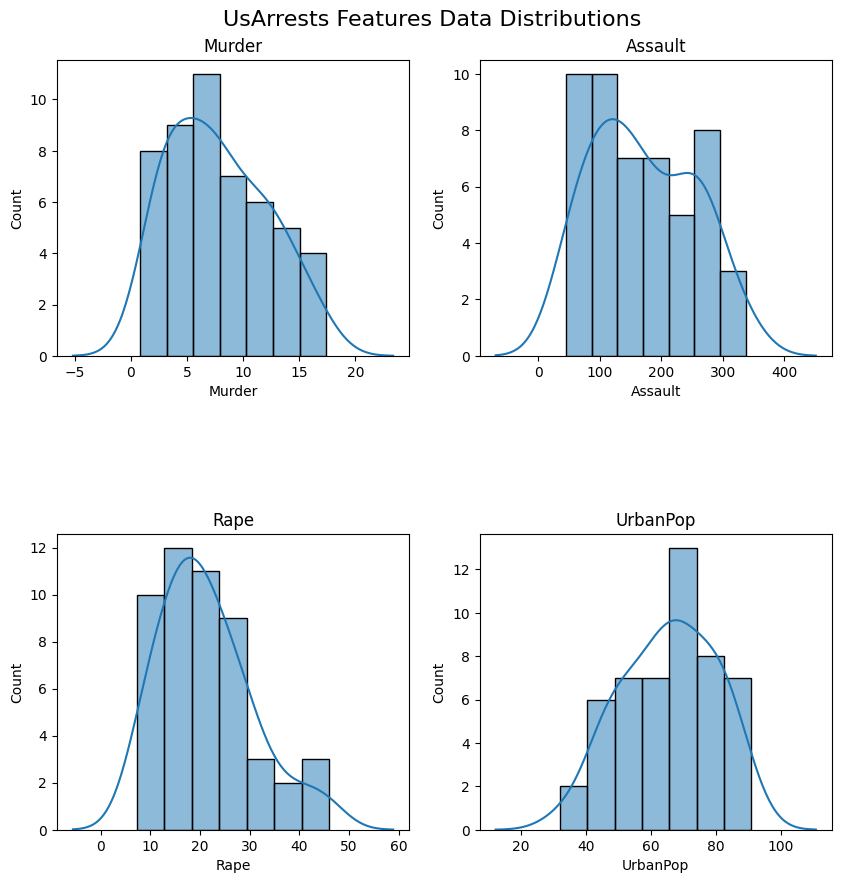

In [72]:
# Create a figure and specify the size
plt.figure(figsize = (10,10))
plt.subplots_adjust(hspace = 0.6)

# Create sup title
plt.suptitle("UsArrests Features Data Distributions", size = 16, y = 0.93)

# Create the first subplot
plt.subplot(2, 2, 1)
sns.histplot(x = "Murder", data = usArrests_df,
             kde = True, kde_kws=dict(cut=3))
plt.title("Murder")

# Create the 2nd subplot
plt.subplot(2, 2, 2)
sns.histplot(x = "Assault", data = usArrests_df,
             kde = True, kde_kws=dict(cut=3))
plt.title("Assault")

# Create the 4th subplot
plt.subplot(2, 2, 3)
sns.histplot(x = "Rape", data = usArrests_df,
             kde = True, kde_kws=dict(cut=3))
plt.title("Rape")

# Create the 3rdsubplot
plt.subplot(2, 2, 4)
sns.histplot(x = "UrbanPop", data = usArrests_df,
             kde = True, kde_kws=dict(cut=3))
plt.title("UrbanPop")



plt.show()

- The positive skew of Murder and Rape suggests that these two forms of arrests have lower count value densities, with fewer states have higher values of murders and rapes.
- Assault is slightly positively skewed tending to being uniform, suggesting the count value densities are similarly spread  there is no concentration of assaults at any specific value.

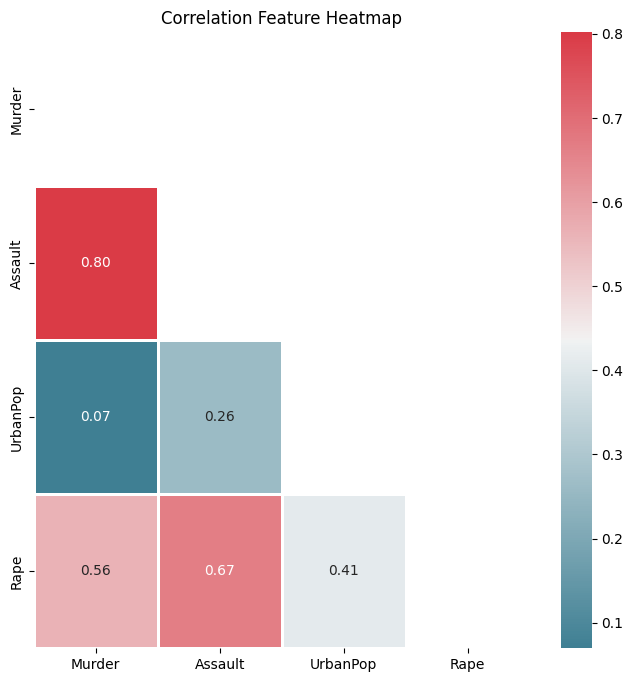

In [73]:
# Selecting colour, Cmpa = True return colourmap object
colormap = sns.diverging_palette(220, 10, as_cmap=True)
corr_heatmap(usArrests_df,colormap)

- We can see that Murder and Assault vary with each other and correlate somewhat strongly. The amount of correlation between 'Murder and Assault' is stronger in comparison to ‘Murder and Rape’ and ‘Assault and Rape’. For developing  initial visualisations, I will consider using either Murder or Assault to explore top level patterns and potential categories. 

- We find the weakest correlation in the dataset being ‘’Murder and UrbanPop’, where we also find ‘Rape and UrbanPop’ being the strongest of the UrbanPop comparisons. As discussed above for ‘Rape and UrbanPop’ this pattern may be influenced by urban environments. Murder rates in comparison are much more uncorrelated and independent of UrbanPop therefore highlighting that urbanisation does not necessarily lead to an increase in murder crime rates. Other factors are probably more likely to affect murder crime rate greater such induvial state laws, and other crime rates not included in this dataset.

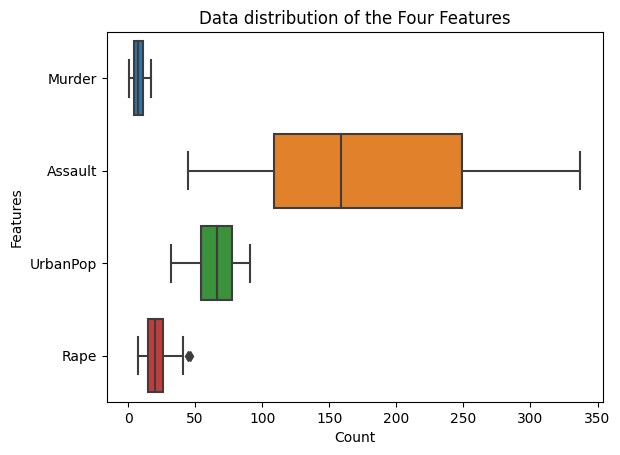

In [74]:
# Creating a bxplot for feature distribution
sns.boxplot(data = usArrests_df, orient = 'h')
plt.ylabel("Features")
plt.xlabel("Count")
plt.title("Data distribution of the Four Features")

# Show plot. 
plt.show()
plt.close()

In [75]:
# Select Data for 3D visualisation
g1 = usArrests_df["UrbanPop"]
g2 = usArrests_df["Assault"]
g3 = usArrests_df["Rape"]

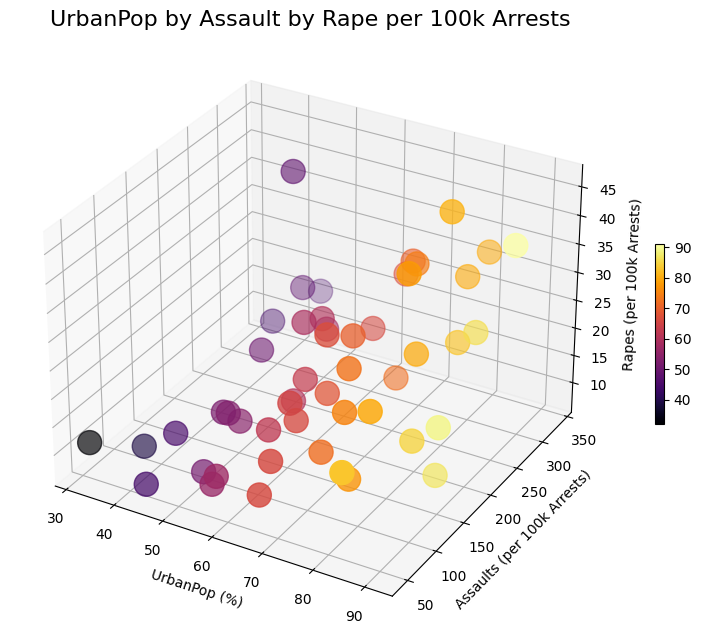

In [76]:
# Create 3d Plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Plot scatter with colour grade
colors = np.where(np.isin(g1, g1), g1, np.nan)
sc = ax.scatter(g1, g2, g3, c = colors, cmap='inferno', s = 300)

# Customise Plot
plt.title("UrbanPop by Assault by Rape per 100k Arrests", size = 16)
plt.subplots_adjust(left=0.1, right=1, bottom=0.2, top=0.8)
plt.colorbar(sc, shrink = 0.3)
ax.set_xlabel('UrbanPop (%)')
ax.set_ylabel('Assaults (per 100k Arrests)')
ax.set_zlabel('Rapes (per 100k Arrests)')

# Show Plot
plt.show()
plt.close()

Concerning distribution, we have a higher range/variance for assault compared to its partners.

A trend is discernible about the 3D plot highlighting  a general rise in assault and rape with an increase in UrbanPop.

# PCA

We have as many Principal Components (PCs) as we have features i.e. 4no. 

The following section will compare and evaluate the impact of using different scaling methods on PCA results. The three methods being compared are: "Unscaled PCA Data", "Standardized PCA Data", and "Normalized PCA Data". The aim is to understand the difference in determining principal components (PCs) when different scaling techniques are applied to the data. 

In each relevant subsection, biplots were generated to visualize the relationships between objects after identifying data redundancies.

### Unscasled PCA Data

In [77]:
# Drop state columns, numpy array, convert to 1D array.
states = usArrests_df.index
labels = usArrests_df.columns
X = usArrests_df.values.squeeze()

# Choose number of components to be generated
nr_comps = 4

# Create PCA class
pca = PCA(n_components = nr_comps)

# Apply PCA to dataset stored in X. 
X_trans = pca.fit_transform(X)

# Create new df for transformed PCA data. 
pca_df = pd.DataFrame(X_trans)
pca_df.head()

,0,1,2,3
0,64.80,11.45,-2.49,2.41
1,92.83,17.98,20.13,-4.09
2,124.07,-8.83,-1.69,-4.35
3,18.34,16.70,0.21,-0.52
4,107.42,-22.52,6.75,-2.81


In [78]:
# Sum of all PC PCA Score values.
sum_pc0 = pca_df[0].sum()
sum_pc1 = pca_df[1].sum()
sum_pc2 = pca_df[2].sum()
sum_pc3 = pca_df[3].sum()

print("PC0 : ", sum_pc0)
print("PC1 : ",sum_pc1)
print("PC2 : ",sum_pc2)
print("PC3 : ",sum_pc3)

PC0 :  5.915268275202834e-13
PC1 :  2.824407374646398e-13
PC2 :  4.121147867408581e-13
PC3 :  -8.471001677889944e-14


In [79]:
# Determine components / load cofficients. 
components_df = pd.DataFrame(pca.components_, 
                          columns=usArrests_df.columns, 
                          index=range(1, nr_comps+1)).transpose()
components_df

,1,2,3,4
Murder,0.04,0.04,0.08,0.99
Assault,1.00,0.06,-0.07,-0.04
UrbanPop,0.05,-0.98,-0.20,0.06
Rape,0.08,-0.20,0.97,-0.07


Above we have showed the loading coefficients for the PCs. Each column represents a PC and each column represents an original feature. Values represent the loading coefficients describing the linear combination of the original features that make up each PC.

E.g.

- PC1, Assault is strongly postively correlated and contributes the most to PC1.
- PC2, UrbanPop is strong negatevly correlated and contributes the most to PC2.
- PC3, Rape is strongly positevely correlated and contributes the most to PC3.
- PC4, Murder is strongly positevely correlated and contributes the most to PC4.

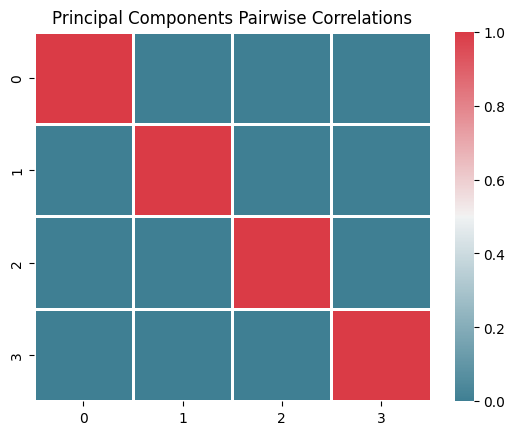

In [80]:
# Pairwise correlations of Principal Components (PCs) for PCA
ax = sns.heatmap(pca_df.corr(), cmap=colormap,linewidth=1)
plt.title("Principal Components Pairwise Correlations")
plt.show()
plt.close()

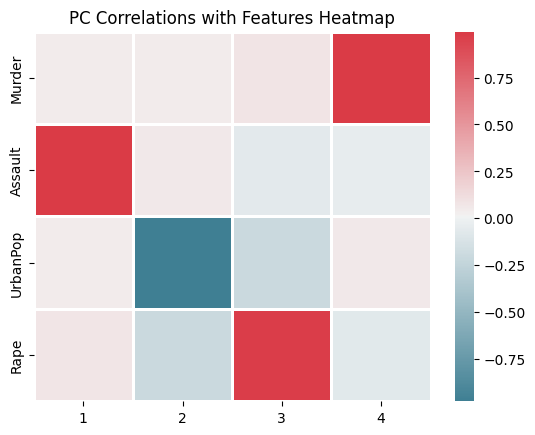

In [81]:
# Heatmap of Compeondent Scores
ax = sns.heatmap(components_df,cmap=colormap,linewidth=1)
plt.title("PC Correlations with Features Heatmap")
plt.show()

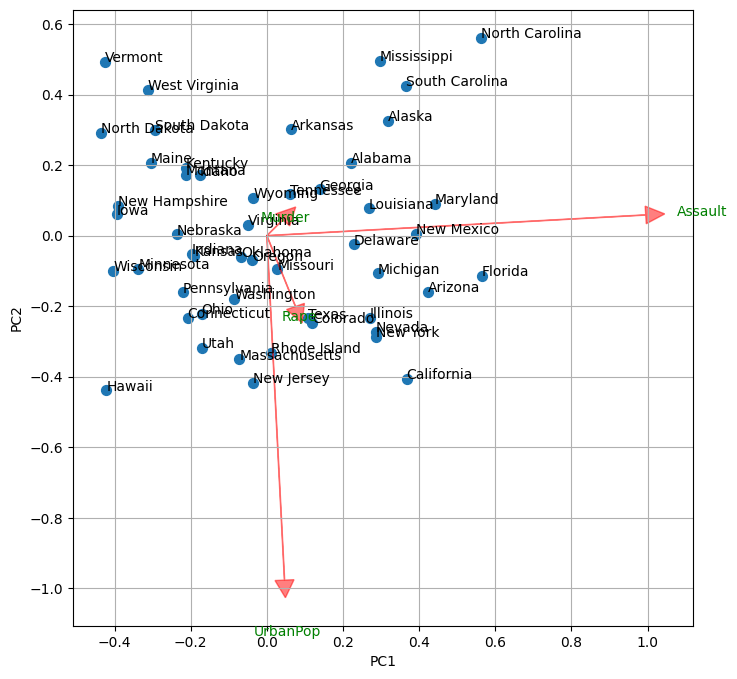

In [82]:
# Plot PCA biplot to visualise results of 1st 2no. PCAs
xlabel = "PC1" 
ylabel = "PC2"
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),
       list(labels),list(states),xlabel, ylabel)
plt.show()

It can be seen that PC1, is somewhat skewed to the right with there being a higher number of assaults in comparison with PC2 which is UrbanPop. With the scale issue with assults those about PC2 there appears to be less variable in comparison to PC1. 

With both UrbanPop and Assult dominated their respective axies, we can determine that diagonally down right is indicative of high assault high urbanpop states, whereas diagonally up left is indicative of low assault low urbanpop states. Interesting outliers would be those diagonally down left i.e. Hawaii, and diagonally up right i.e. North Carolina, South Carolina and mississippi. 

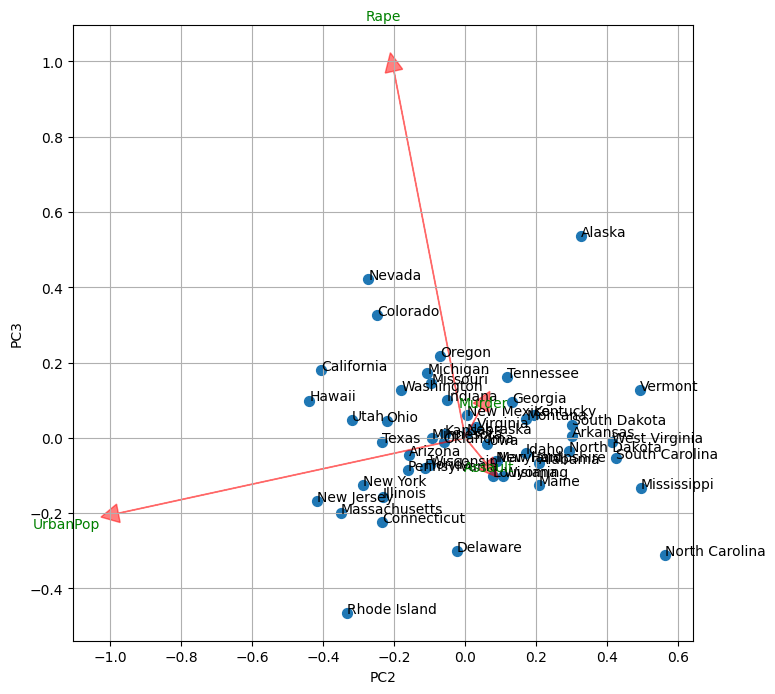

In [83]:
# Plot PCA biplot to visualise results of PCA 2 and PC3
xlabel = "PC2" 
ylabel = "PC3"
biplot(X_trans[:,1:3],np.transpose(pca.components_[1:3, :]),
       list(labels),list(states),xlabel, ylabel)
plt.show()

As above, diagonally up left is higher UrbanPop and rape correlated states i.e. Nevada. Outliers include diagonally up right for high rape low urbanpop i.e. Alaska, or diagonally down left for high urbanpop low rape i.e. Rhose Island. 

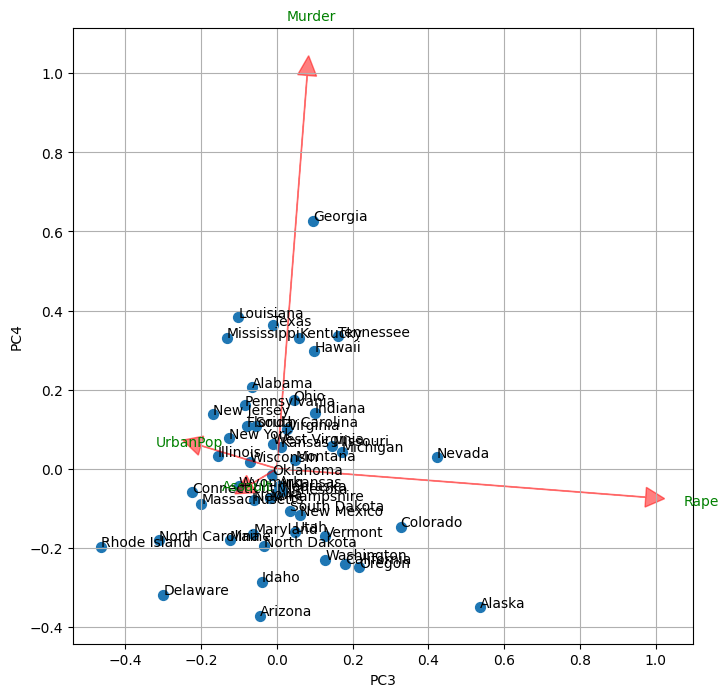

In [84]:
# Plot PCA biplot to visualise results of PC3 and PC4
xlabel = "PC3" 
ylabel = "PC4"
biplot(X_trans[:,2:4],np.transpose(pca.components_[2:4, :]),
       list(labels),list(states),xlabel, ylabel)
plt.show()

As above, diagonally up left for high murder and rape correlated states (no standout states). Outliers include diagonally down right for high rape and low murder i.e. Alaska.

### Standardised Scaled PCA Data

In [85]:
# Select indepdnent and standardise features
scaled = StandardScaler().fit_transform(X)

# Create scaled version of Df
usArrests_std_scaled_df = pd.DataFrame(scaled,columns = usArrests_df.columns[0:4])
usArrests_std_scaled_df.head()

,Murder,Assault,UrbanPop,Rape
0,1.26,0.79,-0.53,-0.00
1,0.51,1.12,-1.22,2.51
2,0.07,1.49,1.01,1.05
3,0.23,0.23,-1.08,-0.19
4,0.28,1.28,1.78,2.09


- Standardising % based feautres create negative values. It may not be appropriate to standardise this dataset. 

In [86]:
# Drop state columns, numpy array, convert to 1D array.
X = usArrests_std_scaled_df.values.squeeze()

# Create PCA class
std_pca = PCA()

# Apply PCA to dataset stored in X. 
X_trans_std = std_pca.fit_transform(X)

# Create new df for transformed PCA data. 
pca_std_df = pd.DataFrame(X_trans_std)
pca_std_df.head()

,0,1,2,3
0,0.99,1.13,-0.44,0.16
1,1.95,1.07,2.04,-0.44
2,1.76,-0.75,0.05,-0.83
3,-0.14,1.12,0.11,-0.18
4,2.52,-1.54,0.60,-0.34


In [87]:
# Sum of all PC PCA Score values.
sum_pc0 = pca_std_df[0].sum()
sum_pc1 = pca_std_df[1].sum()
sum_pc2 = pca_std_df[2].sum()
sum_pc3 = pca_std_df[3].sum()

print("PC0 : ", sum_pc0)
print("PC1 : ",sum_pc1)
print("PC2 : ",sum_pc2)
print("PC3 : ",sum_pc3)

PC0 :  -2.220446049250313e-15
PC1 :  -1.4432899320127035e-15
PC2 :  -1.8041124150158794e-15
PC3 :  9.992007221626409e-16


In [88]:
# Determine components / load cofficients. 
components_std_df = pd.DataFrame(pca.components_, 
                          columns=usArrests_std_scaled_df.columns, 
                          index=range(1, nr_comps+1)).transpose()
components_std_df

,1,2,3,4
Murder,0.04,0.04,0.08,0.99
Assault,1.00,0.06,-0.07,-0.04
UrbanPop,0.05,-0.98,-0.20,0.06
Rape,0.08,-0.20,0.97,-0.07


Feature PC weights description for standardised dataset.

E.g.

- PC1, Murder, Assault and Rape have similar contributes to PC1.
- PC2, UrbanPop is strong negatevly correlated and contributes the most to PC2. 
- PC3, Rape is strongly positevely correlated and contributes the most to PC3.
- PC4, Murder has strong postive correlation whereas Assualt has negative correlation for PC4.

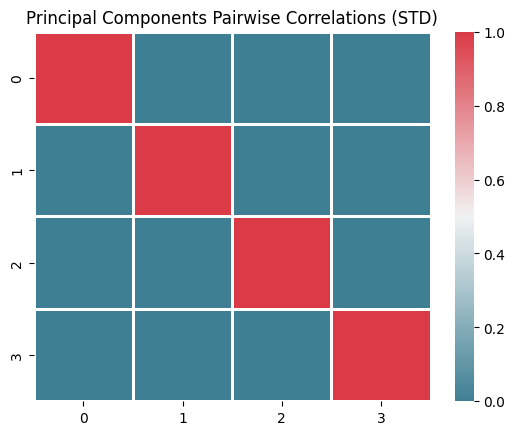

In [89]:
# Pairwise correlations of Principal Components (PCs) for PCA STD
ax = sns.heatmap(pca_std_df.corr(), cmap=colormap,linewidth=1)
plt.title("Principal Components Pairwise Correlations (STD)")
plt.show()
plt.close()

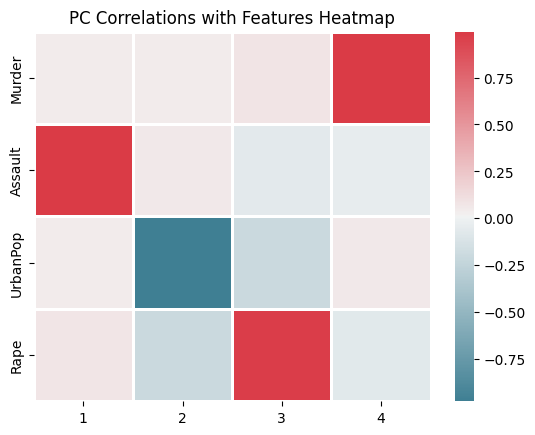

In [90]:
# Heatmap of Component Scores
ax = sns.heatmap(components_std_df,cmap=colormap,linewidth=1)
plt.title("PC Correlations with Features Heatmap")
plt.show()

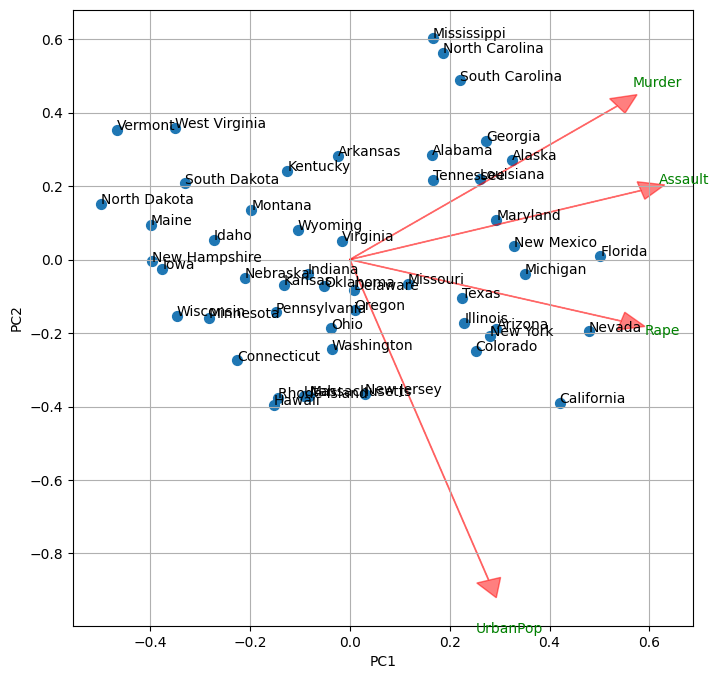

In [91]:
# Plot PCA biplot to visualise results of 1st 2no. PCAs
xlabel = "PC1" 
ylabel = "PC2"
biplot(X_trans_std[:,0:2],np.transpose(std_pca.components_[0:2, :]),
       list(labels),list(states),xlabel, ylabel)
plt.show()

The first principal component (PC1) appears to divide the states into two groups based on high levels of murder, assault, and rape correlations (crime rate). On the other hand, the second principal component (PC2) separates the states based on high or low urban population. 

The data points generally show that states with high urban populations have high crime rates. There are few to no states with low crime rates and high urban populations, which suggests a strong correlation between urban population and crime rate. The outliers in the data, such as Mississippi, North Carolina, and South Carolina, have high crime rates despite having low urban populations, which could indicate a cluster of states with high crime rates regardless of population density.

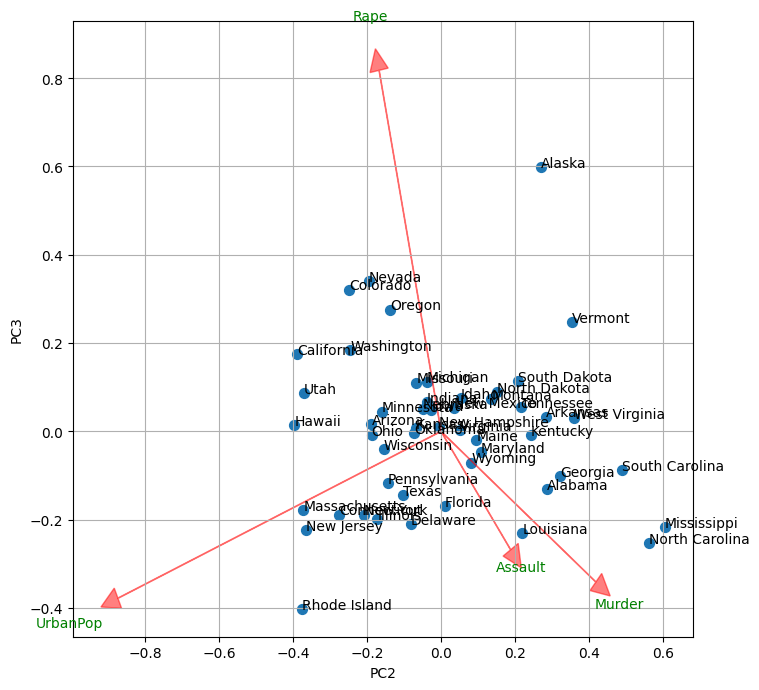

In [92]:
# Plot PCA biplot to visualise results of PC2 and PC3
xlabel = "PC2" 
ylabel = "PC3"
biplot(X_trans_std[:,1:3],np.transpose(std_pca.components_[1:3, :]),
       list(labels),list(states), xlabel, ylabel)
plt.show()

PC2 distinguishes between states with high and low urban populations. On the other hand, PC3 separates states based on the correlation between rape, assault and murder rates.

States like Alaska, Nevada, and Colorado stand out with relatively high rape rates and low assault and murder rates, while Mississippi and North Carolina are outliers with low rape rates and high rates of both murder and assault. 

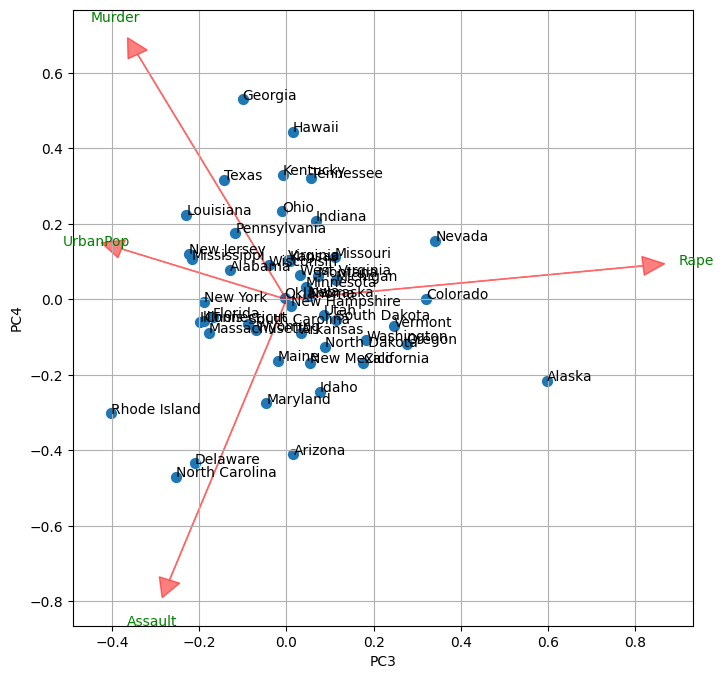

In [93]:
# Plot PCA biplot to visualise results of PC3 and PC4
xlabel = "PC3" 
ylabel = "PC4"
biplot(X_trans_std[:,2:4],np.transpose(std_pca.components_[2:4, :]),
       list(labels),list(states),xlabel, ylabel)
plt.show()

The fourth principal component (PC4) serves to differentiate between the states based on their correlation between Murder and Assault rates. This means that there are states such as Georgia and Hawaii that have a higher correlation between murder rate and a lower correlation between assault rate, while on the other hand, there are states like North Carolina, Delaware and Arizona that have a higher correlation between assault rate and a lower correlation between murder rate.

### Normalised Scaled PCA Data

In [94]:
# MinMaxScaler the independent features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)

# Create scaled version of DataFrame
usArrests_norm_scaled_df = pd.DataFrame(scaled, columns=usArrests_df.columns[0:4])
usArrests_norm_scaled_df.head()

,Murder,Assault,UrbanPop,Rape
0,0.75,0.65,0.44,0.36
1,0.55,0.75,0.27,0.96
2,0.44,0.85,0.81,0.61
3,0.48,0.50,0.31,0.32
4,0.49,0.79,1.00,0.86


In [95]:
# Drop state columns, numpy array, convert to 1D array.
X = usArrests_norm_scaled_df.values.squeeze()

# Create PCA class
norm_pca = PCA()

# Apply PCA to dataset stored in X. 
X_trans = norm_pca.fit_transform(X)

# Create new df for transformed PCA data. 
pca_norm_df = pd.DataFrame(X_trans)
pca_norm_df.head()

,0,1,2,3
0,0.29,0.27,-0.10,0.05
1,0.50,0.23,0.50,-0.13
2,0.46,-0.20,0.00,-0.22
3,-0.01,0.28,0.03,-0.05
4,0.61,-0.41,0.14,-0.09


In [96]:
# Sum of all PC PCA Score values.
sum_pc0 = pca_norm_df[0].sum()
sum_pc1 = pca_norm_df[1].sum()
sum_pc2 = pca_norm_df[2].sum()
sum_pc3 = pca_norm_df[3].sum()

print("PC0 : ", sum_pc0)
print("PC1 : ",sum_pc1)
print("PC2 : ",sum_pc2)
print("PC3 : ",sum_pc3)

PC0 :  -2.220446049250313e-16
PC1 :  -9.159339953157541e-16
PC2 :  -2.5673907444456745e-16
PC3 :  -3.864963904476326e-15


In [97]:
# Determine components / load cofficients. 
components_norm_df = pd.DataFrame(pca.components_, 
                          columns=usArrests_norm_scaled_df.columns, 
                          index=range(1, nr_comps+1)).transpose()
components_norm_df

,1,2,3,4
Murder,0.04,0.04,0.08,0.99
Assault,1.00,0.06,-0.07,-0.04
UrbanPop,0.05,-0.98,-0.20,0.06
Rape,0.08,-0.20,0.97,-0.07


Feature PC weights description for normalised dataset.

E.g.

- PC1, Murder, Assault and Rape have similar contributes to PC1.
- PC2, UrbanPop is strong negatevly correlated and contributes the most to PC2. 
- PC3, Rape is strongly positevely correlated and contributes the most to PC3.
- PC4, Murder has strong postive correlation whereas Assualt has negative correlation for PC4.

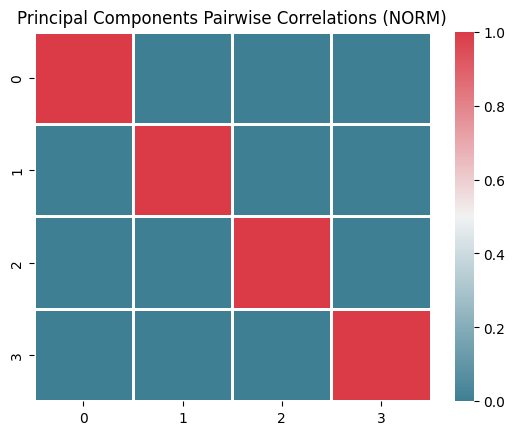

In [98]:
# Pairwise correlations of Principal Components (PCs) for PCA NORM
ax = sns.heatmap(pca_norm_df.corr(), cmap=colormap,linewidth=1)
plt.title("Principal Components Pairwise Correlations (NORM)")
plt.show()
plt.close()

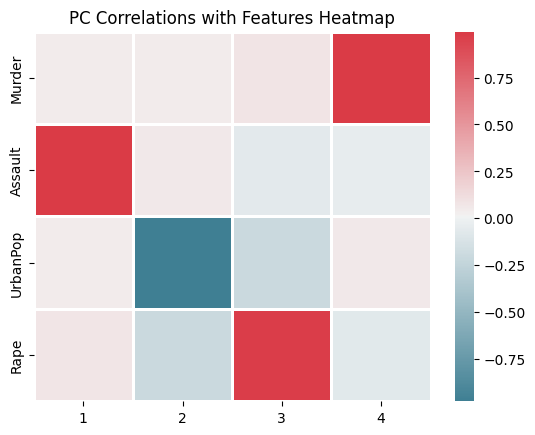

In [99]:
# Heatmap of Component Scores
ax = sns.heatmap(components_norm_df,cmap=colormap,linewidth=1)
plt.title("PC Correlations with Features Heatmap")
plt.show()

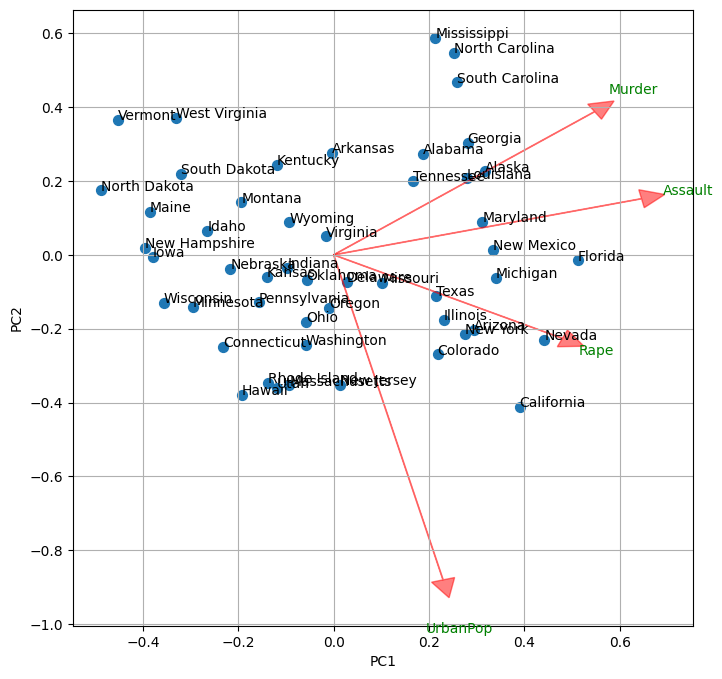

In [100]:
# Plot PCA biplot to visualise results of 1st 2no. PCAs
xlabel = "PC1" 
ylabel = "PC2"
biplot(X_trans[:,0:2],np.transpose(norm_pca.components_[0:2, :]),
       list(labels),list(states),xlabel, ylabel)
plt.show()

No difference vs. Standardised. 

### Scree and Cumulative Varriance Plots

Takeing forward PCA_Std model for clsutering analysis.

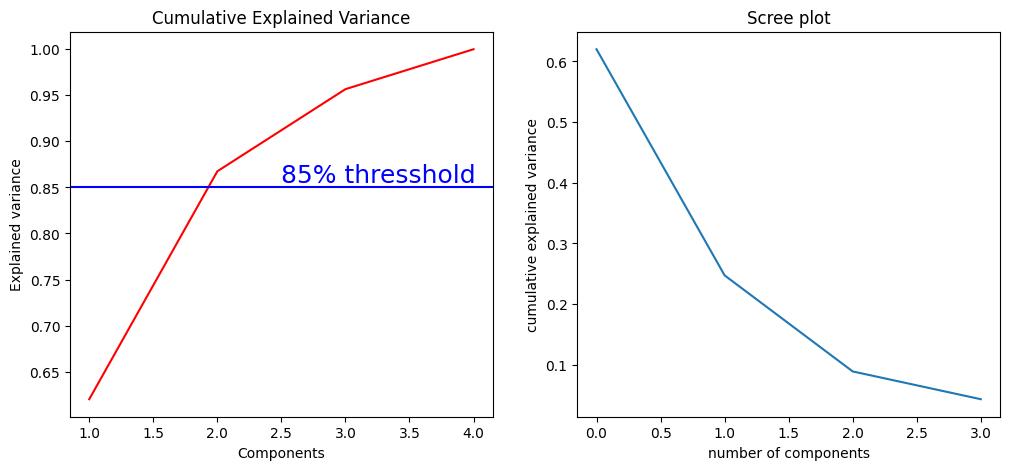

In [101]:
# Subplots for cumulative variance plot and scree plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Cumulative variance plot
axs[0].plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
            np.cumsum(std_pca.explained_variance_ratio_),
            c='red')
axs[0].axhline(y=0.85, color = 'b', linestyle = '-')
axs[0].text(2.5,0.855, '85% thresshold', color = 'blue', fontsize = 18)
axs[0].set_ylabel('Explained variance')
axs[0].set_xlabel('Components')
axs[0].set_title("Cumulative Explained Variance")


# Scree plot
axs[1].plot(std_pca.explained_variance_ratio_)
axs[1].set_xlabel('number of components')
axs[1].set_ylabel('cumulative explained variance')
axs[1].set_title("Scree plot")

plt.show()

The first two Principal Components explain approximately 90% of the variance in the data, and the first three explain approximately 95%. This is indicated by the elbow in the Scree Plot at component number 2. Based on this, we should at minimum consider using PC1 and PC2 for further clustering analysis.

With the first two PCs we are able to get rid of 50% of our data (2/4 PCs) whilt explaining ~86% of how our data deviates or affects each other.

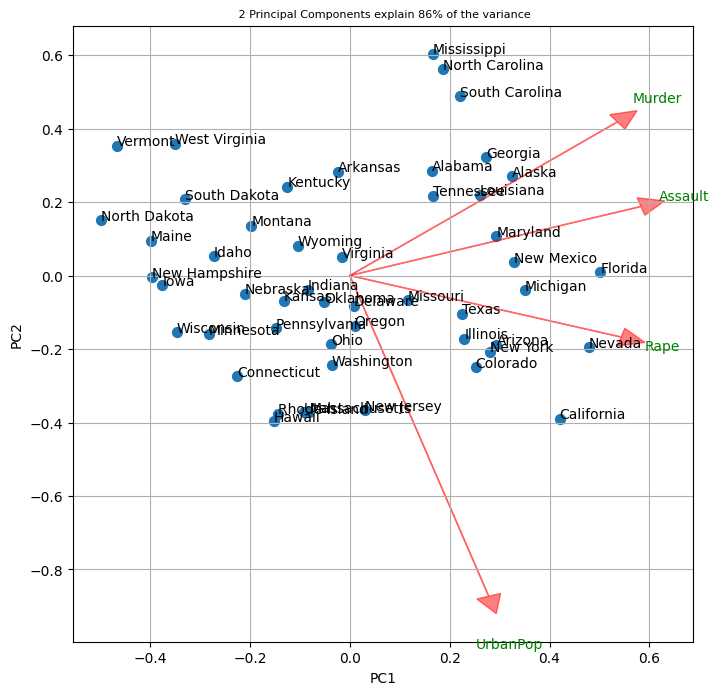

In [102]:
# Reprint, final PCA Biplot for PC1 and PC2 (See above in STD for observations)
title = " 2 Principal Components explain 86% of the variance"
xlabel = "PC1" 
ylabel = "PC2"
biplot(X_trans_std[:,0:2],np.transpose(std_pca.components_[0:2, :]),
       list(labels),list(states), xlabel, ylabel, title)
plt.show()

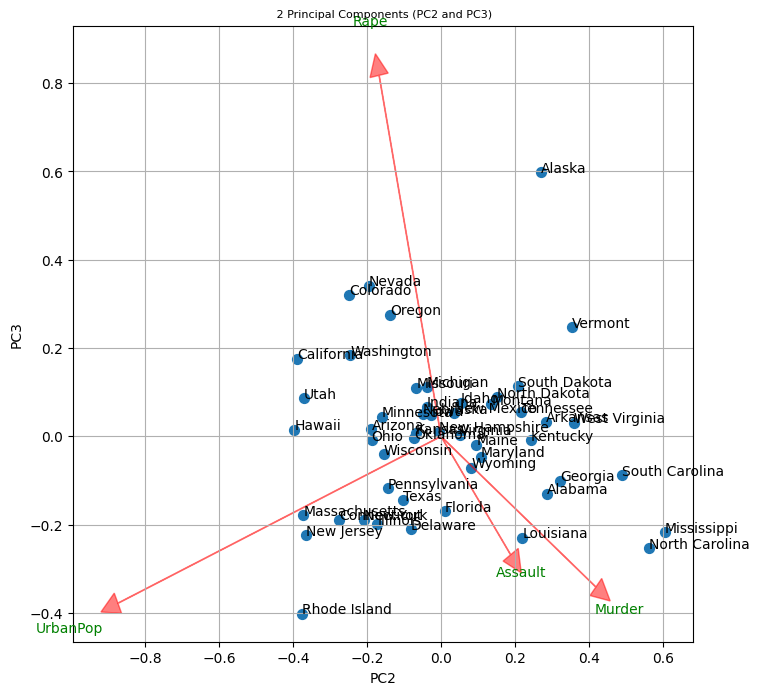

In [103]:
# Reprint, final PCA Biplot for PC2 and PC3 (See above in STD for observations)
title = " 2 Principal Components (PC2 and PC3)"
xlabel = "PC2" 
ylabel = "PC3"
biplot(X_trans_std[:,1:3],np.transpose(std_pca.components_[1:3, :]),
       list(labels),list(states), xlabel, ylabel, title)
plt.show()

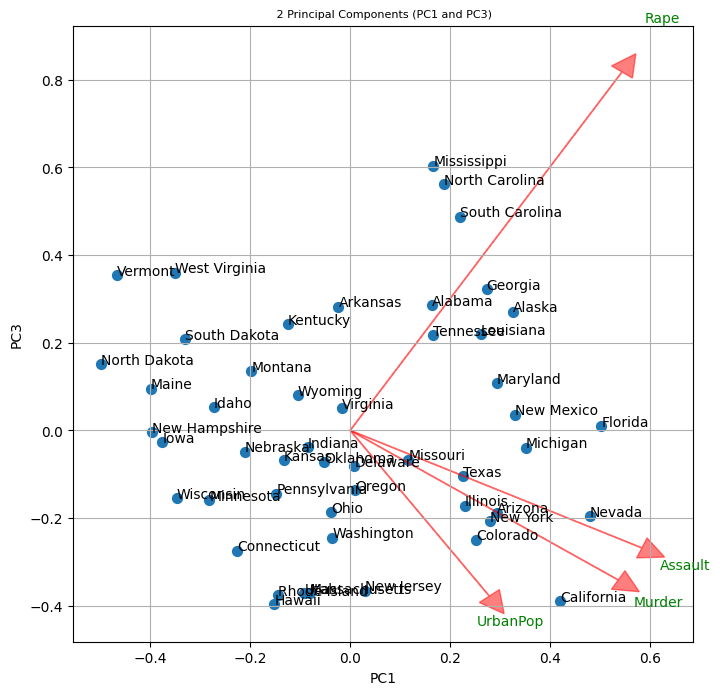

In [104]:
title = " 2 Principal Components (PC1 and PC3)"
xlabel = "PC1" 
ylabel = "PC3"
biplot(X_trans_std[:,0:2],np.transpose(std_pca.components_[[0,2], :]),
       list(labels),list(states), xlabel, ylabel, title)
plt.show()


To activate 3dviewer to see PC1, PC2 and PC3; 
- pip install ipympl, 
- pip install ipywidgets,
- add widget magic command
- To return, delete magic command and restart notebook.

Else amend elevation and x-y plane angles from ax.view() below.

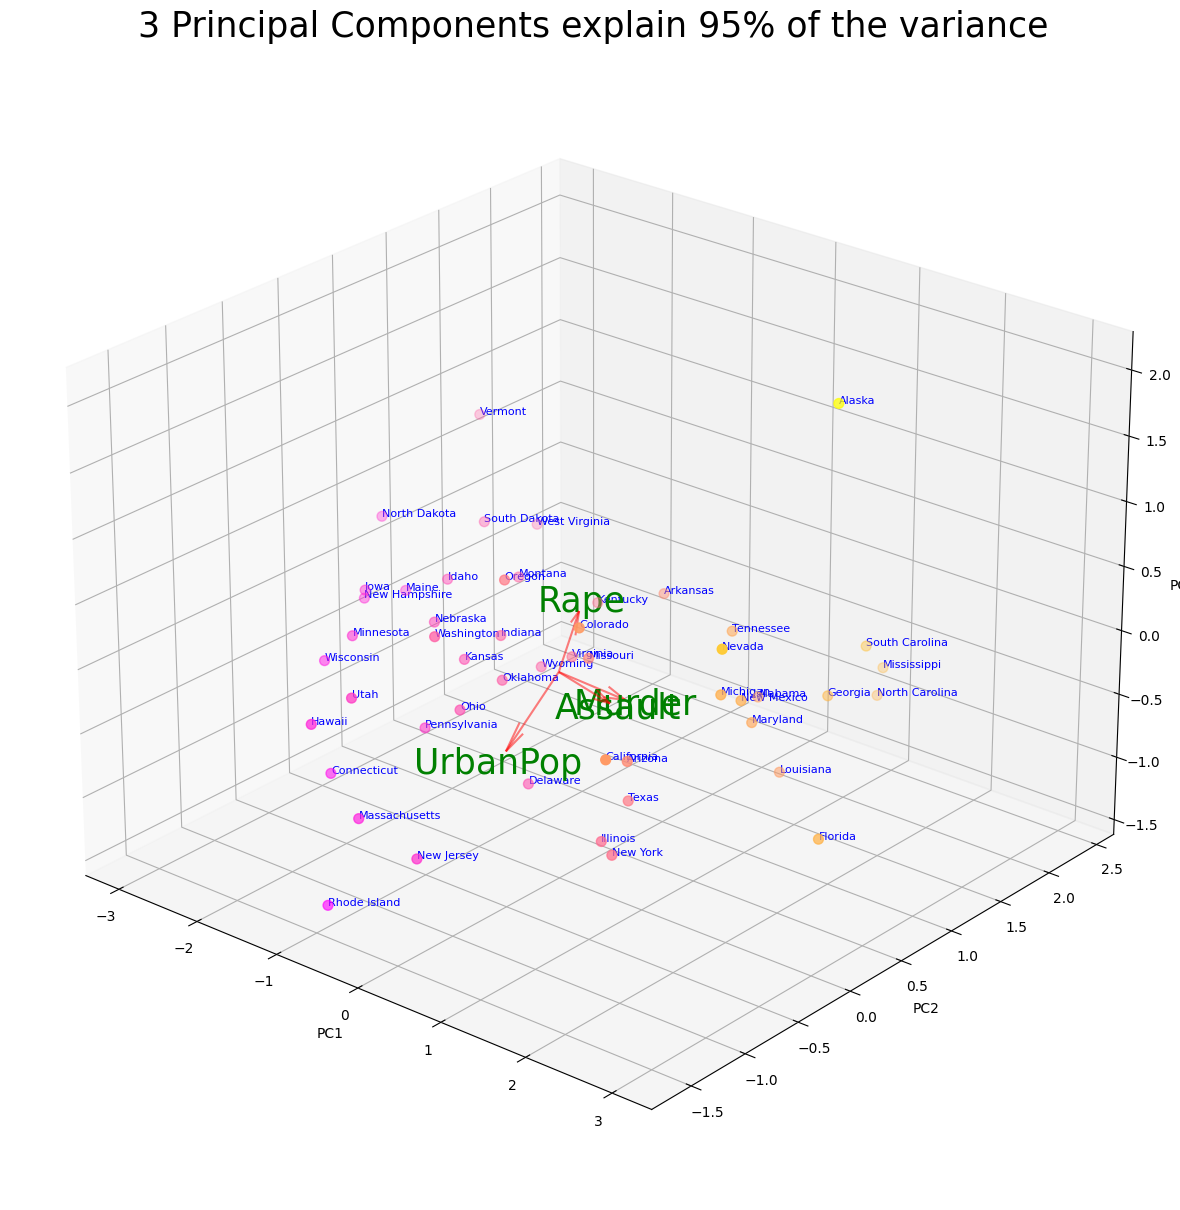

In [105]:
# Modified Biplot for 3D projection of PC1, PC2 and PC3

#  Input data to create 3D Biplot
coeff = np.transpose(std_pca.components_[0:3, :])
                     
xs = X_trans_std[:,0]
ys = X_trans_std[:,1]
zs = X_trans_std[:,2]
n = coeff.shape[0]

scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
scalez = 1.0/(zs.max() - zs.min())

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111,projection ='3d')

# Create 3d Scatter Plot
color_map = plt.get_cmap("spring")
scatter_plot = ax.scatter(X_trans_std[:,0], X_trans_std[:,1], X_trans_std[:,2], 
                          s=50, c = (xs + ys + zs),cmap = color_map)

# Displate state names as  labels.
for i, label in enumerate(states):
    ax.text(X_trans_std[i,0], X_trans_std[i,1], X_trans_std[i,2], 
            label, size=8, zorder=1, color='b')

# Display combined eigenvector by components for PC1, PC2 and PC3.
factor = 0.75
for i in range(n):
    ax.quiver(0, 0, 0, coeff[i,0] *factor, coeff[i,1]*factor, coeff[i,2]*factor, 
              color = 'r', alpha = 0.5)
    if labels is None:
        ax.text(coeff[i,0]*factor * 1.15, coeff[i,1]*factor * 1.15, coeff[i,2]*factor * 1.15, 
                "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
    else:
        ax.text(coeff[i,0]*factor * 1.15, coeff[i,1]*factor * 1.15, coeff[i,2]*factor * 1.15, 
                labels[i], color = 'g', fontsize = 25, ha = 'center', va = 'center')

# Customise graph
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title(" 3 Principal Components explain 95% of the variance", size = 25)

# Change 3D viewing angle
ax.view_init(25,310)

# Show Plot
plt.show()

The 3D plot of PCAs is interesting to view, but more difficult to interpret. For this reason we will only continue with PC1 and PC2 for cluster analysis. 

In [106]:
# Update our std PCA Pandas Dataframe
pca_final_df = pca_std_df.drop(columns = [2,3])
pca_final_df.rename(columns = {0 : "PC1", 1 : "PC2"}, inplace = True)
pca_final_df["State"] = usArrests_copy_df["State"]

pca_final_df.head()

,PC1,PC2,State
0,0.99,1.13,Alabama
1,1.95,1.07,Alaska
2,1.76,-0.75,Arizona
3,-0.14,1.12,Arkansas
4,2.52,-1.54,California


## Cluster Analysis

### Agglometative Hierarchical clustering

In [107]:
# Encode Species names
pca_final_df["State"] = LabelEncoder().fit_transform(pca_final_df["State"])

In [108]:
# Select useful features
X = pca_final_df[['PC1','PC2']].values 

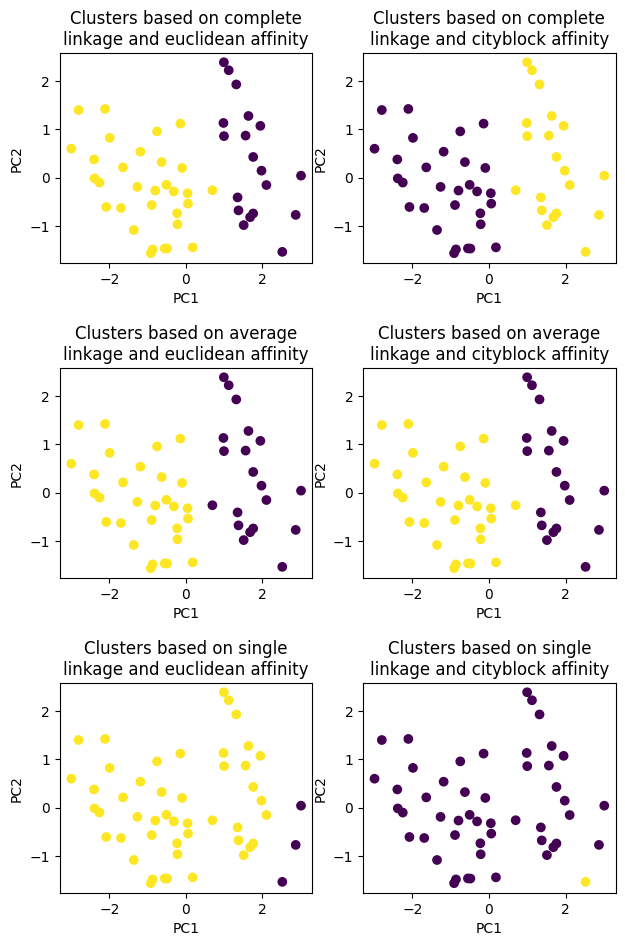

In [109]:
# Print 4no. Agglomerative Cluster Scatters.
fig = plt.figure(figsize=[15,15])

# List linkages/affinity types required.
linkage_types = ['complete', 'average', 'single']
affinity_types = ['euclidean', 'cityblock']

# Look for linkages/affinity types for Agglomerative Cluster Scatters.
for i, l in enumerate(linkage_types):
    for j, a in enumerate(affinity_types):
        plt.subplot(4, 4, (i*4) + j + 1)
        
        # Create AgglomerativeCluster classifiers
        cluster = AgglomerativeClustering(metric=a, linkage=l)
        cluster.fit_predict(X)

        ax = plt.scatter(X[:,0], X[:,1], c=cluster.labels_)
        
        # Customise Plot
        fig.subplots_adjust(wspace=0.2, hspace=0.5)
        plt.title(f'Clusters based on {l}' + 
                  f'\nlinkage and {a} affinity')
        plt.xlabel('PC1')
        plt.ylabel('PC2')

# Show Plot
plt.show()
plt.close()

Linkage module calculate link between the samples of a dataset in the form of a dendrogram, grouping samples into clusters based on their distances. Affinity (metrix) can be applied at this stage.

Despite only showing the 2No. clustwers (as we have not cut the agglo yet), we can see the possible of 3clusters forming given Graph 1 vs. Graph 5. The large initial cluster on the left hand side may possibly split into a 4th cluster...

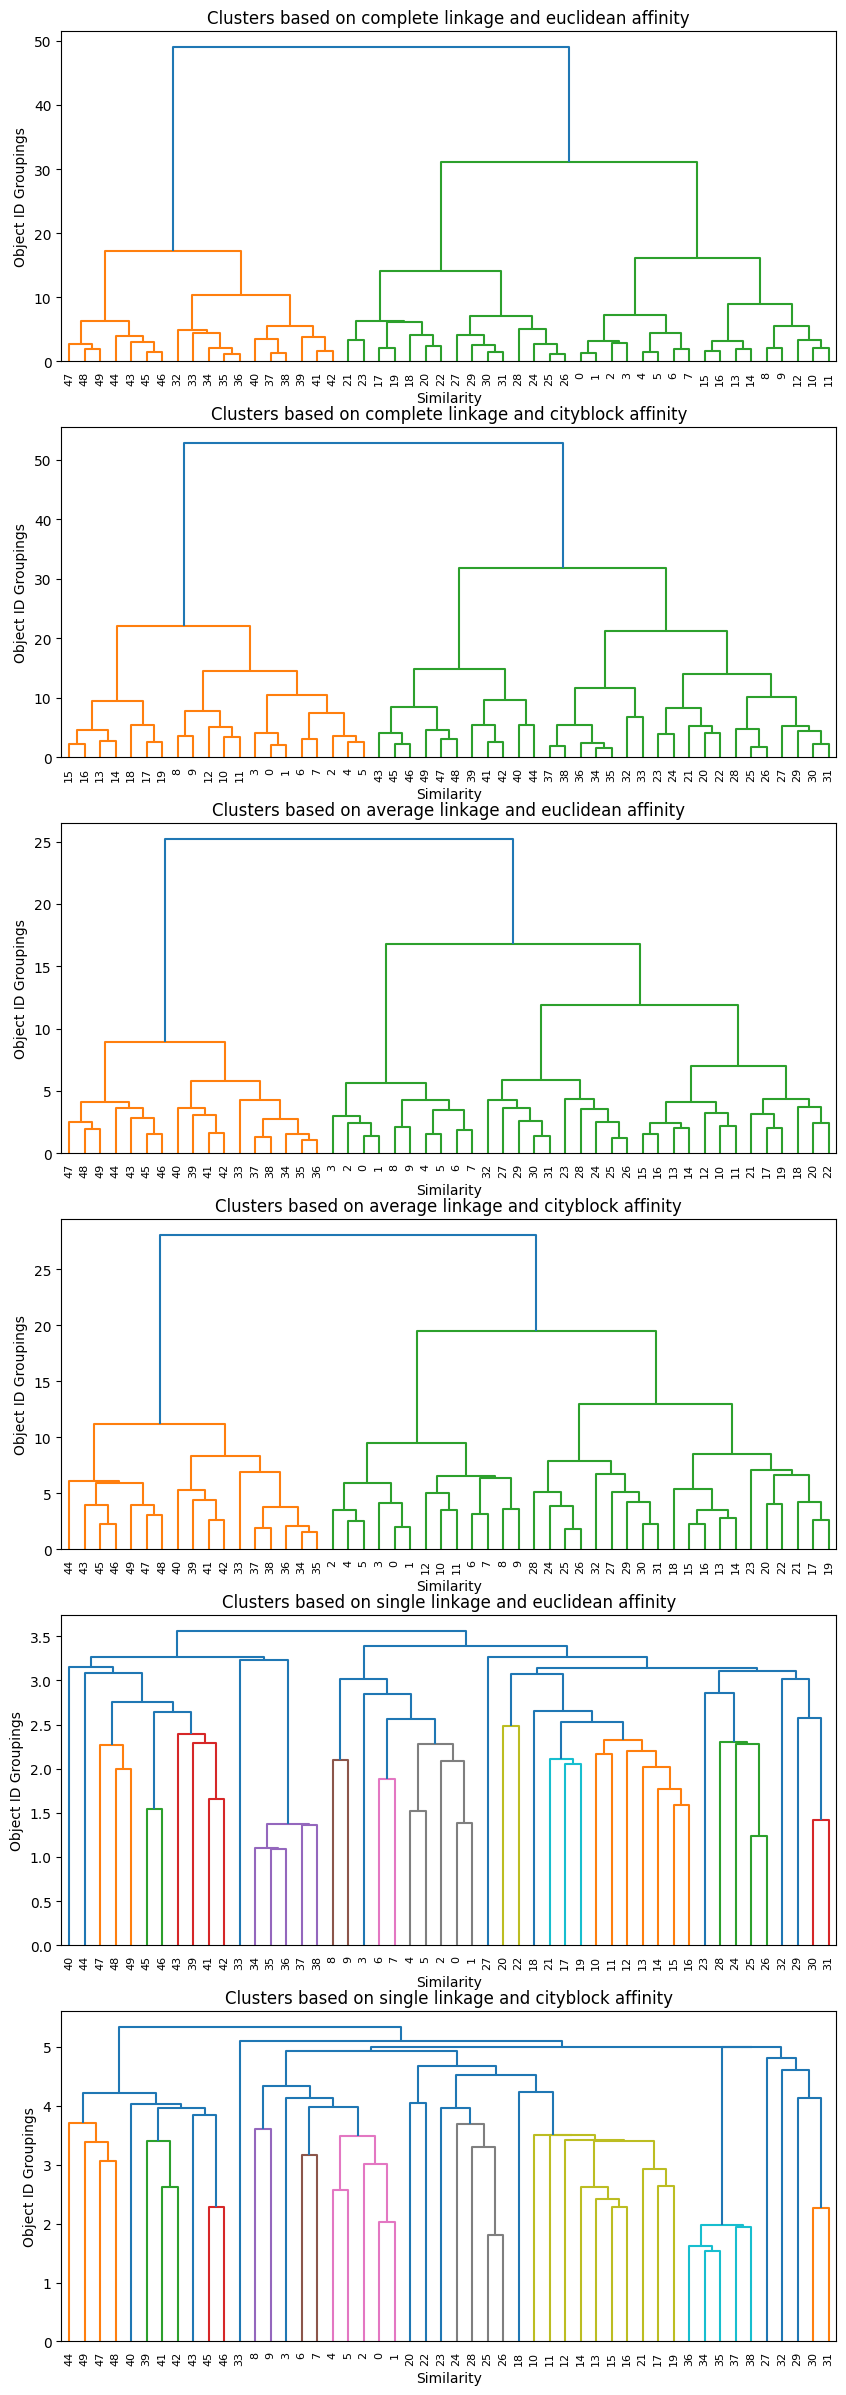

In [110]:
# Print corresponding 4no. dendrograms
plt.figure(figsize=[10,30])

# List linkages/affinity types required.
linkage_types = ['complete', 'average',  'single']
affinity_types = ['euclidean', 'cityblock']

# Look for linkages/affinity types for Dendrograms
for i, l in enumerate(linkage_types):
    for j, a in enumerate(affinity_types):
        plt.subplot(6, 1, (i*2) + j + 1)
        
        # Create Dendrograms
        Z = linkage(pca_final_df, method = l, metric = a)
        dendrogram(Z)
        
        # Customise Plot
        plt.title('Clusters based on {} linkage and {} affinity'.format(l,a))
        plt.xlabel('Similarity')
        plt.ylabel('Object ID Groupings')

# Show Plot
plt.show()
plt.close()

In all cases cityblock had a higher maximum distance compared to euclidean, this is perhaps due to the way distance travels i.e. a euclindean path is shorter as it allows for diagonals...

Single - Long and short cluster formed. Initials pairings have a higher dissimilarity initially. As this linkage is defined by distance between two clusters as the minimum distance between any two points, more prone to cluster merging but good at identifying outliers. As seen the outliers 4, 8 and 27 (bottom right corner of initial cluter plots) identified. 

Average - In this linkage the distance between two clusters is fined as the average distance between any two points from each cluster. 

Complete - More compact clusters with higher similiarity for initial pairings. Linkage is defined by distance between two clusters as the maximum distance between any two points, more defined.

Given the goals of this analysis and the characteristics of the data above, noting some tighness and less defined clusters, we will proceed with linkage 'average' and affinity 'euclidean'. From Graph 3 we will select our K number as 4. 

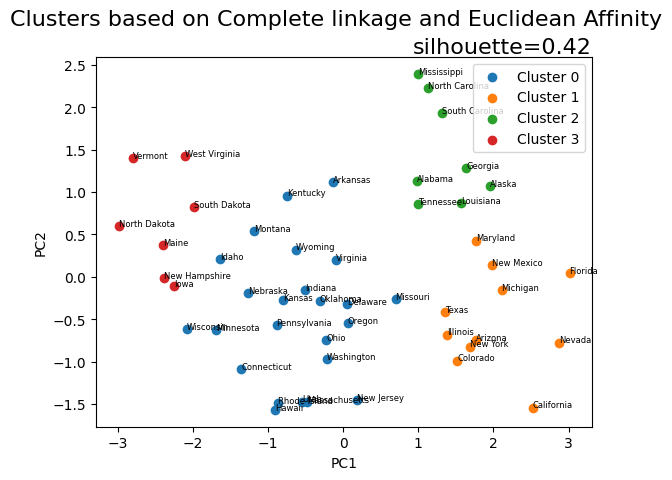

In [111]:
# Select K 
K = 4

# Run AgglomerativeClustering Classifier
cluster = AgglomerativeClustering(n_clusters=K, 
                                  metric ='euclidean', 
                                  linkage = 'complete')
agg_pred= cluster.fit_predict(X)

# Format State index names to list.
states_list = states.tolist()

# Plot predicted values as scatter
for i in range(K):
    mask = (agg_pred == i) # boolean array, index data equal to  0, 1 or 2.
    ax = plt.scatter(X[mask, 0], # Select 1st feature column
                     X[mask, 1], # Select 2nd feature column
                     label='Cluster {}'.format(i))
    
# Calculate Silhoutte Score form sklearn metrics 
score = round(silhouette_score(X, agg_pred, metric='euclidean'),2)
 
# Customise plot
plt.suptitle('Clusters based on Complete linkage and Euclidean Affinity', 
             size = 16)
plt.title('silhouette={}'.format(score), loc='right', 
          fontdict={'fontsize': 16}, pad=-14)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# Add state names as labels
for i, label in enumerate(states_list):
    plt.annotate(label, (X[i,0], X[i,1]), fontsize=6)

# Show plot
plt.show()
plt.close()

####  Evaluation of Agglometative Hierarchical clustering

The Agglomerative Hierarchical clustering applied to the PC1 and PC2 features of the UsArrests dataset resulted in 4 clusters being formed. The clustering appears to have grouped the data relatively well, but the silhouette score indicates that there is some overlap in terms of similarity between the clusters.

Based on PC1, which defines higher murder, assault and rape rates typically towards the upper right, and PC2, which defines higher urban populations towards the lower right, the following conclusions can be made about the clusters:

- Cluster 0 consists of states with low to high-sized urban populations and generally average crime rates. 

- Cluster 1 consists of states with the medium to high urban populations and the higherst average combined crime rates (possibly tending to have higher rape rates based on biplot vector directions). 

- Cluster 2 consists of states with low to medium-sized urban populations but with some of the highest average combined crime rates. 

- Cluster 3 represents states with lower urban populations and the lowest crime rates.

In conclusion, we can see distinctions between both crime rate and urban populations based on the available clusters, with crime rates appearing to be the more defining at this number of clusters. For example, no separate cluster for high urban populations and lower than average crime rates was observed. By increasing the number of clusters to 5, a cluster for states with characteristics like described appears that includes the likes of Hawaii and Rhode Island.

A silhoutte score of 0.44 is indicative that the objects have moderate similiarity between itself and other objects within its own cluster, and moderate dissimilarity between itself and others clusters. The score isn't strong enough to indicate that the object clusters are well defined and distinct, indicating some overlapp is possible. 

### K-means Clustering

C:\Users\karlb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


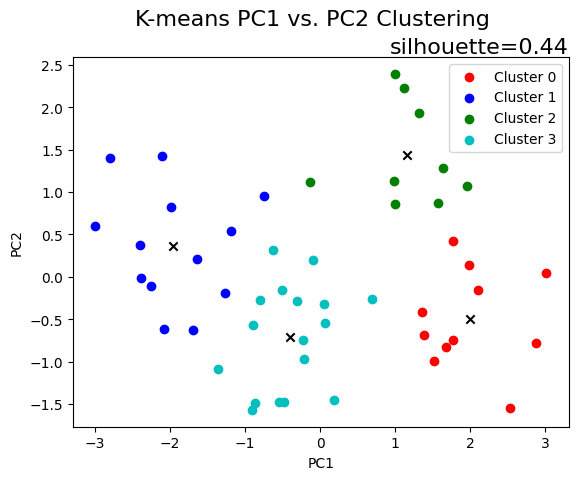

In [112]:
# KNN Clust Classifier Model for Graph 6
for k in range(3,4):
  # Customise plot
  suptitle = "K-means PC1 vs. PC2 Clustering" 
  xlabel = "PC1"
  ylabel =  "PC2"
  
  # Run plot function
  k_pred = scatter_Kmeans(suptitle, xlabel, ylabel, X, 4, r = 42)

In [113]:
# Remap K_pred Cluster numbers to match Agg_Pred for comparison.
for i in range(len(k_pred)):
    if k_pred[i] == 3:
        k_pred[i] = 0
    elif k_pred[i] == 0:
        k_pred[i] = 1
    elif k_pred[i] == 1:
        k_pred[i] = 3
        
print(k_pred)
print(agg_pred)

[2 2 1 2 1 1 0 0 1 2 0 3 1 0 3 0 3 2 3 1 0 1 3 2 0 3 3 1 3 0 1 1 2 3 0 0 0
 0 0 2 3 2 1 0 3 0 0 3 3 0]
[2 2 1 0 1 1 0 0 1 2 0 0 1 0 3 0 0 2 3 1 0 1 0 2 0 0 0 1 3 0 1 1 2 3 0 0 0
 0 0 2 3 2 1 0 3 0 0 3 0 0]


In [114]:
# create confusion matrix (True/Prediction arguement input)
matrix = confusion_matrix(k_pred, agg_pred)

# convert matrix to dataframe
cm_df = pd.DataFrame(matrix, index = ["K-C0", "K-C1", "K-C2", "K-C3"], 
                  columns = ["Agg-C0", "Agg-C1", "Agg-C2", "Agg-C3"])

# display dataframe
cm_df

,Agg-C0,Agg-C1,Agg-C2,Agg-C3
K-C0,17,0,0,0
K-C1,0,11,0,0
K-C2,1,0,8,0
K-C3,6,0,0,7


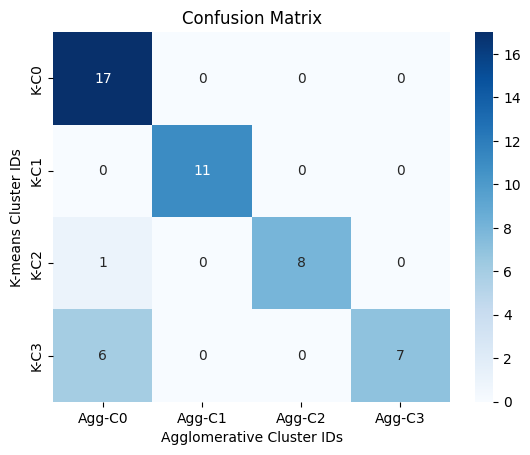

In [115]:
# Convert cm_df to heatmap plot for graph 1
confusion_heatmap(cm_df)

####  Evaluation of K-means and Agglometative Hierarchical clustering results

The results of both K-Means and Agglomerative Clustering models show that Clusters 0 to 4 are similar in terms of distinction and silhoutte scoring, with the silhoutte score being slightly higher for Agglomerative Clustering, but both models providing relatively defined clusters. However, there may be some overlap between objects in these clusters.

Both models did a good job of matching Cluster 1 with no misclassified pairs, which may indicate that Cluster 1 is the most distinct group. Both models also did well in matching Cluster 2, with only one misclassified object, again pointing to a well-defined group.

The biggest difference between the two models was seen in Clusters 0 and 3, which represent mixed low-medium urban populations and crime rates. K-Means grouped states with medium urban populations and lower crime rates, such as Wisconsin, Minnesota, and Idaho, with typically low urban populations and low crime states like Vermont, whereas Agglomerative Clustering did not. This difference highlights the small variance between such states, the less distinct categorical clusters and possibility of overlapping cluster objects. 

In this analysis, there were 7 instances of non-matching clusters between the two models. This highlights the importance of being cautious when dealing with noisy clusters that have lower silhouette scores. Despite this, the results suggest that both methods are successful in identifying compact and well-separated clusters.
